In [3]:
# !pip install q kaggle
tf.__version__


'2.18.0'

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

In [5]:
# !mkdir -p ~/.kaggle


In [ ]:
# !cp /content/drive/MyDrive/Colab Notebooks/ResearchPaper/kaggle.json  ~/.kaggle/kaggle.json
# #


In [7]:
# ! chmod 600 ~/.kaggle/kaggle.json

In [8]:
#!/bin/bash
#!kaggle datasets download vbookshelf/respiratory-sound-database

In [9]:
#!mkdir Dataset

In [10]:
# prompt: save dataset to google drive location /content/drive/MyDrive/ResearchPaper and also Dataset folder coolab

# import shutil

# # Move the downloaded dataset to the specified Google Drive location
# !mkdir -p /content/drive/MyDrive/ResearchPaper/Dataset
# !mv respiratory-sound-database.zip /content/drive/MyDrive/ResearchPaper/Dataset/

# # Copy the downloaded dataset to the Colab Dataset folder
# !mkdir -p Dataset
# !cp /content/drive/MyDrive/ResearchPaper/Dataset/respiratory-sound-database.zip Dataset/

# # Unzip the dataset in both locations
# !unzip /content/drive/MyDrive/ResearchPaper/Dataset/respiratory-sound-database.zip -d /content/drive/MyDrive/ResearchPaper/Dataset/
# !unzip Dataset/respiratory-sound-database.zip -d Dataset/


In [11]:
!pip install numpy 
!pip install matplotlib
!pip install librosa 
!pip install os
!pip install pandas
!pip install scikit-learn
!pip install timeit
!pip install seaborn 
!
from os import listdir
import os
from os.path import isfile, join
import pandas as pd
import librosa
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from timeit import default_timer as timer
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sn
import matplotlib.pyplot as plt
###
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau,CSVLogger
from tensorflow import keras
###
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.layers import Dense, Conv1D, Flatten, Activation, MaxPooling1D, Dropout,Input, GlobalAveragePooling2D, Reshape
from tensorflow.keras.utils import plot_model,to_categorical
from tensorflow.keras.optimizers import Adam


from tensorflow.keras.applications import MobileNetV2
import tensorflow as tf


ERROR: Could not find a version that satisfies the requirement os (from versions: none)
ERROR: No matching distribution found for os
ERROR: Could not find a version that satisfies the requirement timeit (from versions: none)
ERROR: No matching distribution found for timeit


# Parsing the Dataset

In [12]:
class Diagnosis():
  def __init__ (self, id, diagnosis, image_path):
    self.id = id
    self.diagnosis = diagnosis
    self.image_path = image_path

In [13]:
def get_wav_files():
  audio_path = 'Respiratory_Sound_Database/audio_and_txt_files/'
  files = [f for f in listdir(audio_path) if isfile(join(audio_path, f))]  #Gets all files in dir
  wav_files = [f for f in files if f.endswith('.wav')]  # Gets wav files
  wav_files = sorted(wav_files)
  return wav_files, audio_path

In [14]:
def diagnosis_data():
  diagnosis = pd.read_csv('Respiratory_Sound_Database/patient_diagnosis.csv')

  wav_files, audio_path = get_wav_files()
  diag_dict = { 101 : "URTI"}
  diagnosis_list = []

  for index , row in diagnosis.iterrows():
    diag_dict[row[0]] = row[1]

  c = 0
  for f in wav_files:
    diagnosis_list.append(Diagnosis(c, diag_dict[int(f[:3])], audio_path+f))
    c+=1

  return diagnosis_list

# Feature Extraction

In [15]:
def audio_features(filename):
  sound, sample_rate = librosa.load(filename)
  stft = np.abs(librosa.stft(sound))

  mfccs = np.mean(librosa.feature.mfcc(y=sound, sr=sample_rate, n_mfcc=40),axis=1)
  chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate),axis=1)
  mel = np.mean(librosa.feature.melspectrogram(y=sound, sr=sample_rate), axis=1)
  contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate),axis=1)
  tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(sound), sr=sample_rate),axis=1)

  concat = np.concatenate((mfccs,chroma,mel,contrast,tonnetz))
  return concat

def data_points():
  labels = []
  images = []

  to_hot_one = {"COPD":0, "Healthy":1, "URTI":2, "Bronchiectasis":3, "Pneumonia":4, "Bronchiolitis":5, "Asthma":6, "LRTI":7}

  count = 0
  for f in diagnosis_data():
    print(count)
    labels.append(to_hot_one[f.diagnosis])
    images.append(audio_features(f.image_path))
    count+=1

  return np.array(labels), np.array(images)

# Preprocessing

In [16]:
def preprocessing(labels, images):

  # Remove Asthma and LRTI
  images = np.delete(images, np.where((labels == 7) | (labels == 6))[0], axis=0)
  labels = np.delete(labels, np.where((labels == 7) | (labels == 6))[0], axis=0)

  # Split data
  X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=10)

  # Hot one encode the labels
  y_train = to_categorical(y_train)
  y_test = to_categorical(y_test)

  # Format new data
  y_train = np.reshape(y_train, (y_train.shape[0], 6))
  X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
  y_test = np.reshape(y_test, (y_test.shape[0], 6))
  X_test = np.reshape(X_test, (X_test.shape[0], X_train.shape[1],  1))

  return X_train, X_test, y_train, y_test

## Callbacks

In [17]:
os.makedirs('model/cdd_resnet_aug',exist_ok=True)
save_dir='model/cdd_resnet_aug/cdd_resnet_aug.keras'
checkpoint = keras.callbacks.ModelCheckpoint(save_dir,
                                            monitor='accuracy',
                                            save_best_only=True,
                                            verbose=1,
                                            mode='auto',
                                            save_freq=163)

early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                            patience=20,
                                            mode='auto',
                                            verbose=1,
                                            restore_best_weights=True)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                            factor=0.1,
                                            min_delta=.0001)
csvlogger =  tf.keras.callbacks.CSVLogger('model/cdd_resnet_aug/log.csv',
                                        separator=',',
                                        append=True)
callbacks = [checkpoint, early_stopping, reduce_lr,csvlogger]

In [18]:
# labels, images = data_points()
# X_train, X_test, y_train, y_test = preprocessing(labels, images)

In [19]:
start = timer()

labels, images = data_points()
X_train, X_test, y_train, y_test = preprocessing(labels, images)


0


/tmp/ipykernel_15096/596380246.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  diag_dict[row[0]] = row[1]
/home/nazmus/Documents/Habibul/.venv/lib/python3.11/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


1


/home/nazmus/Documents/Habibul/.venv/lib/python3.11/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
27

/home/nazmus/Documents/Habibul/.venv/lib/python3.11/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


909
910
911
912
913
914
915
916
917
918
919


# MobileNetV2

In [20]:
X_train.shape

(733, 193, 1)

In [21]:
# Step 1: Reshape (733, 193, 1) → (733, 14, 14, 1)
def reshape_features(X):
    X_reshaped = np.zeros((X.shape[0], 14, 14, 1))  # 14x14 grid with 1 channel
    X_reshaped[:, :13, :14, 0] = X[:, :182, 0].reshape(-1, 13, 14)  # Fill with data
    return X_reshaped

X_train_reshaped = reshape_features(X_train)
X_test_reshaped = reshape_features(X_test)

In [22]:
# Step 1: Reshape (733, 193, 1) → (733, 14, 14, 1)
def reshape_features(X):
    X_reshaped = np.zeros((X.shape[0], 14, 14, 1))  # 14x14 grid with 1 channel
    X_reshaped[:, :13, :14, 0] = X[:, :182, 0].reshape(-1, 13, 14)  # Fill with data
    return X_reshaped

X_train_reshaped = reshape_features(X_train)
X_test_reshaped = reshape_features(X_test)

# Step 2: Expand to 3 Channels (For MobileNetV2)
X_train_expanded = np.repeat(X_train_reshaped, 3, axis=-1)  # Shape: (733, 14, 14, 3)
X_test_expanded = np.repeat(X_test_reshaped, 3, axis=-1)

# Step 3: Resize to MobileNetV2 Input (96×96×3)
X_train_resized = tf.image.resize(X_train_expanded, (96, 96))
X_test_resized = tf.image.resize(X_test_expanded, (96, 96))

# Step 4: Define MobileNetV2 Model
input_tensor = Input(shape=(96, 96, 3))  # MobileNetV2 requires 3 channels
base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=input_tensor)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
output = Dense(6, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# Step 5: Compile and Train
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train_resized, y_train, validation_data=(X_test_resized, y_test), epochs=100, batch_size=200, verbose=1)

I0000 00:00:1738340300.786527   15096 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3382 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9
/tmp/ipykernel_15096/2705800345.py:20: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=input_tensor)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 5s 1us/step
Epoch 1/100


/home/nazmus/Documents/Habibul/.venv/lib/python3.11/site-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 96, 96, 3))
  warnings.warn(msg)
I0000 00:00:1738340317.634014   19334 service.cc:148] XLA service 0x7fa1f40168d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1738340317.634050   19334 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4050 Laptop GPU, Compute Capability 8.9
2025-01-31 22:18:38.003083: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1738340319.173392   19334 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-01-31 22:18:39.646939: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:930] The NVIDIA driver's CUDA version is 12.2 which is older th

3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.4792 - loss: 1.3914

2025-01-31 22:19:04.730645: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7432', 4 bytes spill stores, 4 bytes spill loads

2025-01-31 22:19:05.045487: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7432', 220 bytes spill stores, 220 bytes spill loads

2025-01-31 22:19:05.117336: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7432_0', 708 bytes spill stores, 420 bytes spill loads

2025-01-31 22:19:05.320469: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7432', 252 bytes spill stores, 252 bytes spill loads

2025-01-31 22:19:05.812647: I external/local_xla/xla/s

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.5302 - loss: 1.2913   

2025-01-31 22:19:25.065971: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1181', 4 bytes spill stores, 4 bytes spill loads

2025-01-31 22:19:25.206605: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1181', 220 bytes spill stores, 220 bytes spill loads

2025-01-31 22:19:25.310604: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1181', 252 bytes spill stores, 252 bytes spill loads

2025-01-31 22:19:25.449339: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1181_0', 708 bytes spill stores, 420 bytes spill loads



4/4 ━━━━━━━━━━━━━━━━━━━━ 64s 10s/step - accuracy: 0.5609 - loss: 1.2313 - val_accuracy: 0.8967 - val_loss: 4.8535
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step - accuracy: 0.8544 - loss: 0.5415 - val_accuracy: 0.8967 - val_loss: 5.3264
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 0.8557 - loss: 0.3535 - val_accuracy: 0.8967 - val_loss: 5.6662
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.8798 - loss: 0.2603 - val_accuracy: 0.8967 - val_loss: 6.2297
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 0.9128 - loss: 0.2129 - val_accuracy: 0.8967 - val_loss: 6.3211
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 0.9229 - loss: 0.1922 - val_accuracy: 0.8967 - val_loss: 6.5392
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.9236 - loss: 0.1663 - val_accuracy: 0.8967 - val_loss: 6.8372
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step - accuracy: 0.9468 - loss: 0.1267 - val_accuracy: 0.8967 - val_loss: 7.04

# Evaluation

In [ ]:
score = model.evaluate(X_test_resized, y_test, batch_size=60, verbose=0)
print('Accuracy: {0:.0%}'.format(score[1]/1))
print("Loss: %.4f\n" % score[0])

# Plot accuracy and loss graphs
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label = 'training acc')
plt.plot(history.history['val_accuracy'], label = 'validation acc')
plt.legend()

plt.subplot(1,2,2)
plt.title('Loss')
plt.plot(history.history['loss'], label = 'training loss')
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.legend()

# Custom 1D-CNN + LSTM

In [24]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Dropout, Flatten, Dense, LSTM, Reshape

model1 = Sequential()

# Add Conv1D layers for feature extraction
model1.add(Conv1D(64, kernel_size=5, activation='relu', input_shape=(193, 1)))
model1.add(Conv1D(128, kernel_size=5, activation='relu'))
model1.add(MaxPooling1D(2))

# Add additional Conv1D layer
model1.add(Conv1D(256, kernel_size=5, activation='relu'))

# Add Dropout for regularization
model1.add(Dropout(0.3))

# Reshape the output to 3D for LSTM
model1.add(Reshape((-1, 256)))

# Add LSTM layer for sequential modeling
model1.add(LSTM(128, activation='relu', return_sequences=False))

# Fully connected Dense layers
model1.add(Dense(512, activation='relu'))
model1.add(Dense(6, activation='softmax'))

# Compile the model
model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history1 = model1.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=200, verbose=1)


Epoch 1/100


/home/nazmus/Documents/Habibul/.venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-01-31 22:20:34.994246: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_28_0', 404 bytes spill stores, 260 bytes spill loads

2025-01-31 22:20:35.505151: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_29', 96 bytes spill stores, 96 bytes spill loads

2025-01-31 22:20:36.373603: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 6.42GiB wit

1/4 ━━━━━━━━━━━━━━━━━━━━ 14s 5s/step - accuracy: 0.0500 - loss: 12.2765

2025-01-31 22:20:38.742120: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_28_0', 404 bytes spill stores, 260 bytes spill loads

2025-01-31 22:20:39.274006: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_29', 84 bytes spill stores, 84 bytes spill loads

2025-01-31 22:20:39.950766: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.28GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.3819 - loss: 6.7013 - val_accuracy: 0.8967 - val_loss: 0.4741
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8535 - loss: 2.7342 - val_accuracy: 0.8967 - val_loss: 1.3361
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.8565 - loss: 23.1595 - val_accuracy: 0.8967 - val_loss: 192.3576
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8612 - loss: 609.9599 - val_accuracy: 0.8424 - val_loss: 45.2063
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6532 - loss: 26.7686 - val_accuracy: 0.4022 - val_loss: 53.0723
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6416 - loss: 34.8379 - val_accuracy: 0.8533 - val_loss: 2.9818
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8381 - loss: 8.4029 - val_accuracy: 0.8913 - val_loss: 4.3361
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8486 - loss: 8.8926 - val_accuracy: 0.8859 - val_loss: 5.85

## Evaluation for Custom 1D-CNN + LSTM

Accuracy: 87%
Loss: 480610048.0000



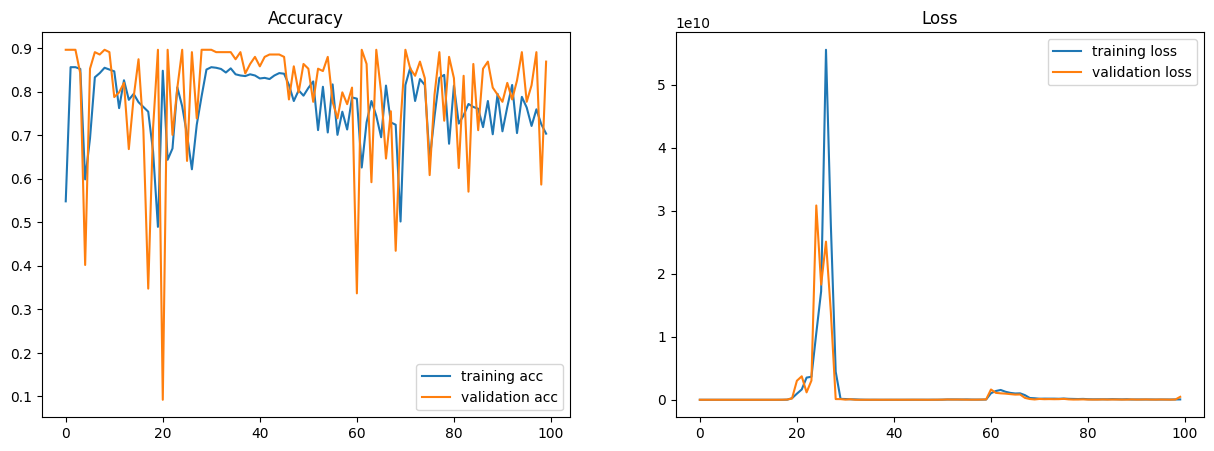

In [25]:
score1 = model1.evaluate(X_test, y_test, batch_size=60, verbose=0)
print('Accuracy: {0:.0%}'.format(score1[1]/1))
print("Loss: %.4f\n" % score1[0])

# Plot accuracy and loss graphs
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.title('Accuracy')
plt.plot(history1.history['accuracy'], label = 'training acc')
plt.plot(history1.history['val_accuracy'], label = 'validation acc')
plt.legend()

plt.subplot(1,2,2)
plt.title('Loss')
plt.plot(history1.history['loss'], label = 'training loss')
plt.plot(history1.history['val_loss'], label = 'validation loss')
plt.legend()

# Spectrogram + ResNet/EfficientNet

In [26]:
X_train.shape

(733, 193, 1)

In [27]:

from tensorflow.keras.applications import ResNet50, EfficientNetB0
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input
from tensorflow.keras.models import Model

# Reshape the input data to match EfficientNetB0's expected input shape
X_train_resized = tf.image.resize(X_train_reshaped, [96, 96])
X_test_resized = tf.image.resize(X_test_reshaped, [96, 96])

# Choose the base model (EfficientNetB0)
input_tensor = Input(shape=(96, 96, 3))
base_model1 = EfficientNetB0(weights='imagenet', include_top=False, input_tensor=input_tensor)

# Freeze pretrained layers
for layer in base_model1.layers:
    layer.trainable = False

# Custom layers
x1 = Flatten()(base_model1.output)
x1 = Dense(512, activation='relu')(x1)
x1 = Dense(6, activation='softmax')(x1)

# Compile the model
model2 = Model(inputs=base_model1.input, outputs=x1)
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history2 = model2.fit(X_train_resized, y_train, validation_data=(X_test_resized, y_test), epochs=100, batch_size=200, verbose=1)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 10s 1us/step
Epoch 1/100


/home/nazmus/Documents/Habibul/.venv/lib/python3.11/site-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_203']
Received: inputs=Tensor(shape=(None, 96, 96, 1))
  warnings.warn(msg)


4/4 ━━━━━━━━━━━━━━━━━━━━ 23s 4s/step - accuracy: 0.4771 - loss: 4.3497 - val_accuracy: 0.8967 - val_loss: 3.7078
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.8454 - loss: 4.8210 - val_accuracy: 0.7011 - val_loss: 1.3689
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.7192 - loss: 1.4026 - val_accuracy: 0.8478 - val_loss: 0.6662
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.8278 - loss: 0.7549 - val_accuracy: 0.8804 - val_loss: 0.5669
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.8465 - loss: 0.9014 - val_accuracy: 0.8913 - val_loss: 0.4297
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8481 - loss: 0.5175 - val_accuracy: 0.8913 - val_loss: 0.3671
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.8580 - loss: 0.4794 - val_accuracy: 0.8967 - val_loss: 0.3263
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.8579 - loss: 0.4883 - val_accuracy: 0.9022 - val_loss: 0.3317
Epoch

# Evaluation for Spectrogram + ResNet/EfficientNet

Accuracy: 92%
Loss: 0.2318



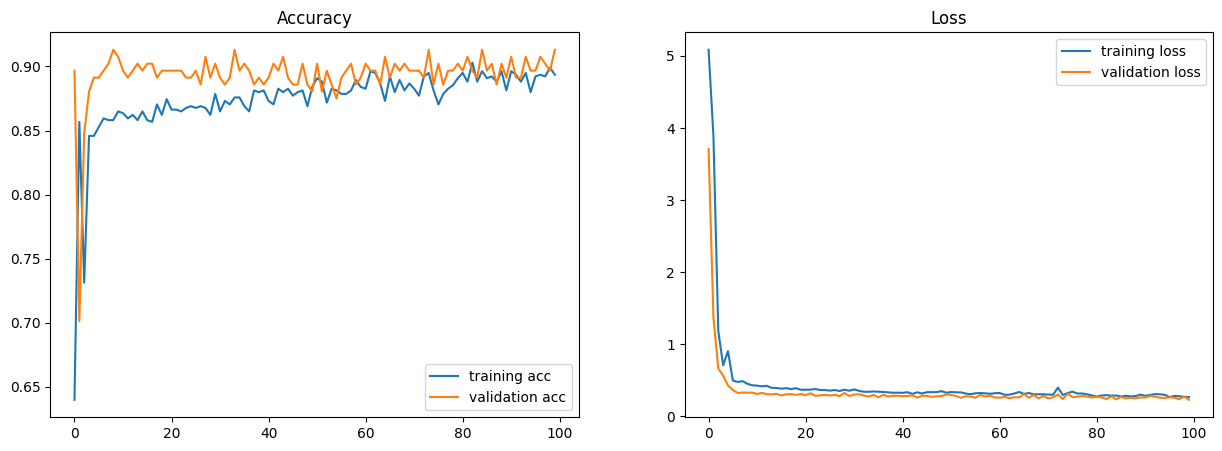

In [28]:
score2 = model2.evaluate(X_test_resized, y_test, batch_size=60, verbose=0)
print('Accuracy: {0:.0%}'.format(score2[1]/1))
print("Loss: %.4f\n" % score2[0])

# Plot accuracy and loss graphs
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.title('Accuracy')
plt.plot(history2.history['accuracy'], label = 'training acc')
plt.plot(history2.history['val_accuracy'], label = 'validation acc')
plt.legend()

plt.subplot(1,2,2)
plt.title('Loss')
plt.plot(history2.history['loss'], label = 'training loss')
plt.plot(history2.history['val_loss'], label = 'validation loss')
plt.legend()

# Attention-Based CNN Models CBAM

In [29]:
"""
import tensorflow as tf
from keras.layers import Input, Conv1D, MaxPooling1D, Dropout, Flatten, Dense, Multiply, Reshape
from keras.models import Model

# CBAM Module (Convolutional Block Attention Module)
class CBAM(tf.keras.layers.Layer):
    def __init__(self, channel_attention=True, spatial_attention=True, **kwargs):
        super(CBAM, self).__init__(**kwargs)
        self.channel_attention = channel_attention
        self.spatial_attention = spatial_attention

    def build(self, input_shape):
        pass

    def call(self, inputs):
        # Channel Attention
        if self.channel_attention:
            channel_avg = tf.reduce_mean(inputs, axis=1, keepdims=True)
            channel_max = tf.reduce_max(inputs, axis=1, keepdims=True)
            channel_attention = tf.sigmoid(channel_avg + channel_max)
            inputs = Multiply()([inputs, channel_attention])

        # Spatial Attention
        if self.spatial_attention:
            spatial_avg = tf.reduce_mean(inputs, axis=-1, keepdims=True)
            spatial_max = tf.reduce_max(inputs, axis=-1, keepdims=True)
            spatial_attention = tf.sigmoid(spatial_avg + spatial_max)
            inputs = Multiply()([inputs, spatial_attention])

        return inputs

# Define the attention-based CNN model using CBAM
input_shape = (193, 193, 1)

input_layer = Input(shape=input_shape)
x2 = Reshape((193, 193))(input_layer)  # Reshape to match Conv1D input shape
x2 = Conv1D(64, kernel_size=5, activation='relu')(x2)
x2 = CBAM()(x2)  # Applying CBAM
x2 = Conv1D(128, kernel_size=5, activation='relu')(x2)
x2 = MaxPooling1D(2)(x2)
x2 = CBAM()(x2)  # Applying CBAM
x2 = Conv1D(256, kernel_size=5, activation='relu')(x2)
x2 = Dropout(0.3)(x2)
x2 = Flatten()(x2)

x2 = Dense(512, activation='relu')(x2)
x2 = Dense(6, activation='softmax')(x2)

model3 = Model(inputs=input_layer, outputs=x2)

# Compile the model
model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit the model
history3 = model3.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=200, verbose=1)
"""
import tensorflow as tf
from keras.layers import Input, Conv1D, MaxPooling1D, Dropout, Flatten, Dense, Multiply
from keras.models import Model

# CBAM Module (Convolutional Block Attention Module)
class CBAM(tf.keras.layers.Layer):
    def __init__(self, channel_attention=True, spatial_attention=True, **kwargs):
        super(CBAM, self).__init__(**kwargs)
        self.channel_attention = channel_attention
        self.spatial_attention = spatial_attention

    def build(self, input_shape):
        pass

    def call(self, inputs):
        # Channel Attention
        if self.channel_attention:
            channel_avg = tf.reduce_mean(inputs, axis=1, keepdims=True)
            channel_max = tf.reduce_max(inputs, axis=1, keepdims=True)
            channel_attention = tf.sigmoid(channel_avg + channel_max)
            inputs = Multiply()([inputs, channel_attention])

        # Spatial Attention
        if self.spatial_attention:
            spatial_avg = tf.reduce_mean(inputs, axis=-1, keepdims=True)
            spatial_max = tf.reduce_max(inputs, axis=-1, keepdims=True)
            spatial_attention = tf.sigmoid(spatial_avg + spatial_max)
            inputs = Multiply()([inputs, spatial_attention])

        return inputs

# Define the attention-based CNN model using CBAM
input_shape = (193, 1)

input_layer = Input(shape=input_shape)
x2 = Conv1D(64, kernel_size=5, activation='relu')(input_layer)
x2 = CBAM()(x2)  # Applying CBAM
x2 = Conv1D(128, kernel_size=5, activation='relu')(x2)
x2 = MaxPooling1D(2)(x2)
x2 = CBAM()(x2)  # Applying CBAM
x2 = Conv1D(256, kernel_size=5, activation='relu')(x2)
x2 = Dropout(0.3)(x2)
x2 = Flatten()(x2)

x2 = Dense(512, activation='relu')(x2)
x2 = Dense(6, activation='softmax')(x2)

model3 = Model(inputs=input_layer, outputs=x2)

# Compile the model
model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit the model
history3 = model3.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=150, batch_size=200, verbose=1)


Epoch 1/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 578ms/step - accuracy: 0.5215 - loss: 6.4974 - val_accuracy: 0.8967 - val_loss: 2.8138
Epoch 2/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7792 - loss: 3.1857 - val_accuracy: 0.7935 - val_loss: 1.2094
Epoch 3/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7402 - loss: 2.6135 - val_accuracy: 0.8641 - val_loss: 2.1023
Epoch 4/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8198 - loss: 5.0890 - val_accuracy: 0.8696 - val_loss: 1.7940
Epoch 5/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8423 - loss: 3.7606 - val_accuracy: 0.8859 - val_loss: 1.0854
Epoch 6/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8608 - loss: 2.4853 - val_accuracy: 0.8587 - val_loss: 0.6773
Epoch 7/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.8097 - loss: 1.0682 - val_accuracy: 0.8967 - val_loss: 0.4293
Epoch 8/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8579 - loss: 0.5745 - val_accuracy: 0.8967 - val_loss

# Evaluation Attention-Based CNN Models CBAM

Accuracy: 95%
Loss: 0.2597



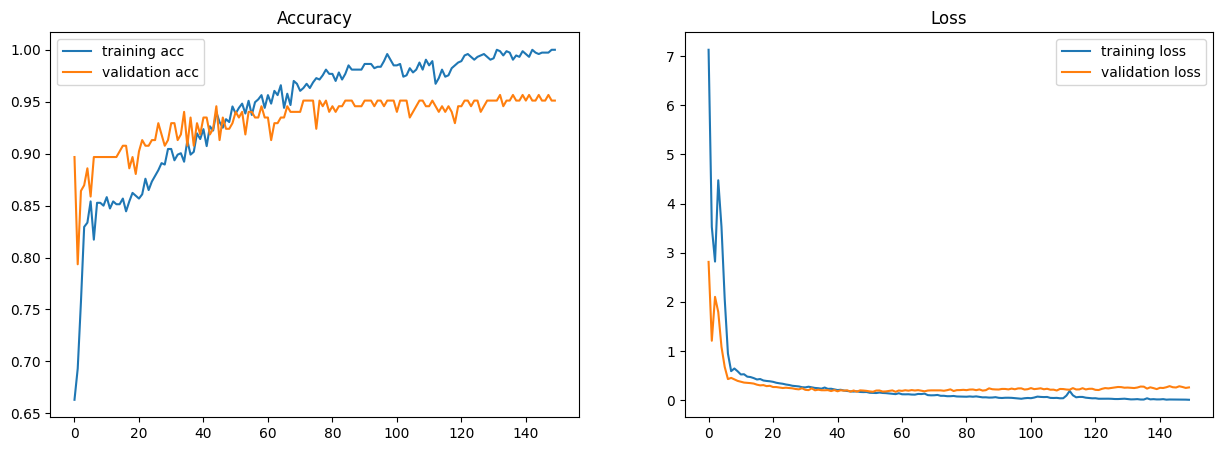

In [30]:
score3 = model3.evaluate(X_test, y_test, batch_size=60, verbose=0)
print('Accuracy: {0:.0%}'.format(score3[1]/1))
print("Loss: %.4f\n" % score3[0])

# Plot accuracy and loss graphs
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.title('Accuracy')
plt.plot(history3.history['accuracy'], label = 'training acc')
plt.plot(history3.history['val_accuracy'], label = 'validation acc')
plt.legend()

plt.subplot(1,2,2)
plt.title('Loss')
plt.plot(history3.history['loss'], label = 'training loss')
plt.plot(history3.history['val_loss'], label = 'validation loss')
plt.legend()

# OpenL3


In [31]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# Use the reshaped and resized data
X_train_resized = tf.image.resize(X_train_reshaped, [193, 193])
X_test_resized = tf.image.resize(X_test_reshaped, [193, 193])

# Load a pretrained EfficientNetB0 model
base_model4 = EfficientNetB0(include_top=False, input_shape=(193, 193, 3), weights="imagenet")
base_model4.trainable = False  # Freeze the base model layers

# Add custom classification layers
model4 = Sequential([
    base_model4,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(6, activation='softmax')  # Adjust the output units to match your classes
])

# Compile the model
model4.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Train the model
history4 = model4.fit(
    X_train_resized, y_train,
    validation_data=(X_test_resized, y_test),
    epochs=100,
    batch_size=200,
    verbose=1
)


Epoch 1/100


2025-01-31 22:22:28.908375: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_10891', 212 bytes spill stores, 212 bytes spill loads

2025-01-31 22:22:34.364938: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 820.00MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-01-31 22:22:34.365002: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 820.00MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-01-31 22:22:34.365015: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory

3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.3928 - loss: 1.4205

2025-01-31 22:22:51.161158: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_10891', 296 bytes spill stores, 420 bytes spill loads

E0000 00:00:1738340581.391020   19335 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1738340581.490666   19335 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.4562 - loss: 1.3320   

E0000 00:00:1738340594.215332   19334 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1738340594.397881   19334 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1738340601.922170   19334 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1738340602.064596   19334 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


4/4 ━━━━━━━━━━━━━━━━━━━━ 63s 12s/step - accuracy: 0.4943 - loss: 1.2789 - val_accuracy: 0.8967 - val_loss: 0.6394
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 201ms/step - accuracy: 0.8565 - loss: 0.8093 - val_accuracy: 0.8967 - val_loss: 0.5012
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step - accuracy: 0.8585 - loss: 0.6166 - val_accuracy: 0.8967 - val_loss: 0.5477
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 231ms/step - accuracy: 0.8567 - loss: 0.6264 - val_accuracy: 0.8967 - val_loss: 0.4510
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 226ms/step - accuracy: 0.8507 - loss: 0.6009 - val_accuracy: 0.8967 - val_loss: 0.4245
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 201ms/step - accuracy: 0.8575 - loss: 0.5678 - val_accuracy: 0.8967 - val_loss: 0.4237
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 200ms/step - accuracy: 0.8514 - loss: 0.5589 - val_accuracy: 0.8967 - val_loss: 0.4186
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 217ms/step - accuracy: 0.8574 - loss: 0.5350 - val_accuracy: 0.8967 - val_loss: 0.39

# Evaluation of OpenL3


E0000 00:00:1738340689.797687   19334 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1738340689.887853   19334 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1738340689.979229   19334 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1738340690.069663   19334 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1738340690.160630   19334 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

Accuracy: 90%
Loss: 0.2979



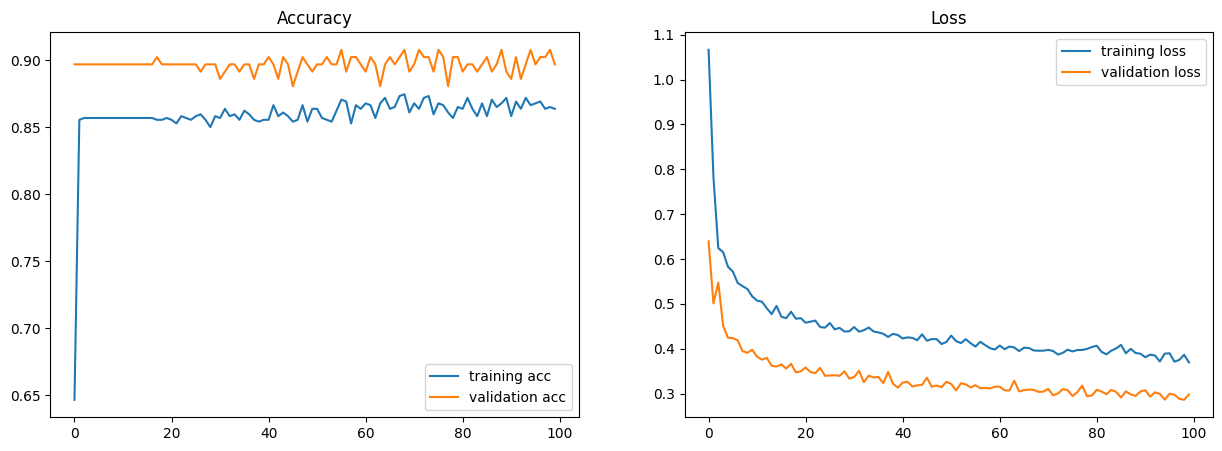

In [32]:
score4 = model4.evaluate(X_test_resized, y_test, batch_size=60, verbose=0)
print('Accuracy: {0:.0%}'.format(score4[1]/1))
print("Loss: %.4f\n" % score4[0])

# Plot accuracy and loss graphs
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.title('Accuracy')
plt.plot(history4.history['accuracy'], label = 'training acc')
plt.plot(history4.history['val_accuracy'], label = 'validation acc')
plt.legend()

plt.subplot(1,2,2)
plt.title('Loss')
plt.plot(history4.history['loss'], label = 'training loss')
plt.plot(history4.history['val_loss'], label = 'validation loss')
plt.legend()

# PANNs (Pre-trained Audio Neural Networks)

In [33]:
# Reshape the data to have 3 channels
X_train_expanded = np.repeat(X_train_reshaped, 3, axis=-1)  # Replicate the 1-channel input to 3 channels
X_test_expanded = np.repeat(X_test_reshaped, 3, axis=-1)    # Same for test data

# Resize the data to match the expected input shape of ResNet50
X_train_resized = tf.image.resize(X_train_expanded, [193, 193])
X_test_resized = tf.image.resize(X_test_expanded, [193, 193])

# Define the model
input_tensor = Input(shape=(193, 193, 3))  # 3 channels (RGB)
base_model5 = ResNet50(weights='imagenet', include_top=False, input_tensor=input_tensor)

# Add custom layers
x5 = base_model5.output
x5 = GlobalAveragePooling2D()(x5)
x5 = Dense(512, activation='relu')(x5)
output = Dense(6, activation='softmax')(x5)

# Define the complete model
model5 = Model(inputs=base_model5.input, outputs=output)

# Compile the model
model5.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history5 = model5.fit(X_train_resized, y_train, validation_data=(X_test_resized, y_test), epochs=100,callbacks=callbacks, batch_size=200, verbose=1)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 54s 1us/step
Epoch 1/100


/home/nazmus/Documents/Habibul/.venv/lib/python3.11/site-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_699']
Received: inputs=Tensor(shape=(None, 193, 193, 3))
  warnings.warn(msg)
2025-01-31 22:26:08.996578: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_14794', 4 bytes spill stores, 4 bytes spill loads

2025-01-31 22:26:09.207563: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_14794', 224 bytes spill stores, 224 bytes spill loads

2025-01-31 22:26:09.243442: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_15012_0', 92 bytes spill stores, 92 bytes spill loads

2025-01-

ResourceExhaustedError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/home/nazmus/Documents/Habibul/.venv/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/nazmus/Documents/Habibul/.venv/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/nazmus/Documents/Habibul/.venv/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/nazmus/Documents/Habibul/.venv/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.11/asyncio/base_events.py", line 607, in run_forever

  File "/usr/lib/python3.11/asyncio/base_events.py", line 1922, in _run_once

  File "/usr/lib/python3.11/asyncio/events.py", line 80, in _run

  File "/home/nazmus/Documents/Habibul/.venv/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/home/nazmus/Documents/Habibul/.venv/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/home/nazmus/Documents/Habibul/.venv/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/home/nazmus/Documents/Habibul/.venv/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/home/nazmus/Documents/Habibul/.venv/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/home/nazmus/Documents/Habibul/.venv/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/home/nazmus/Documents/Habibul/.venv/lib/python3.11/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/nazmus/Documents/Habibul/.venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3077, in run_cell

  File "/home/nazmus/Documents/Habibul/.venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3132, in _run_cell

  File "/home/nazmus/Documents/Habibul/.venv/lib/python3.11/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/home/nazmus/Documents/Habibul/.venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3336, in run_cell_async

  File "/home/nazmus/Documents/Habibul/.venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3519, in run_ast_nodes

  File "/home/nazmus/Documents/Habibul/.venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3579, in run_code

  File "/tmp/ipykernel_15096/1192280995.py", line 26, in <module>

  File "/home/nazmus/Documents/Habibul/.venv/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/nazmus/Documents/Habibul/.venv/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 371, in fit

  File "/home/nazmus/Documents/Habibul/.venv/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 219, in function

  File "/home/nazmus/Documents/Habibul/.venv/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 132, in multi_step_on_iterator

Out of memory while trying to allocate 10851139904 bytes.
	 [[{{node StatefulPartitionedCall}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_multi_step_on_iterator_181953]

# Evaluation of PANNs (Pre-trained Audio Neural Networks)

Accuracy: 90%
Loss: 1705.8938



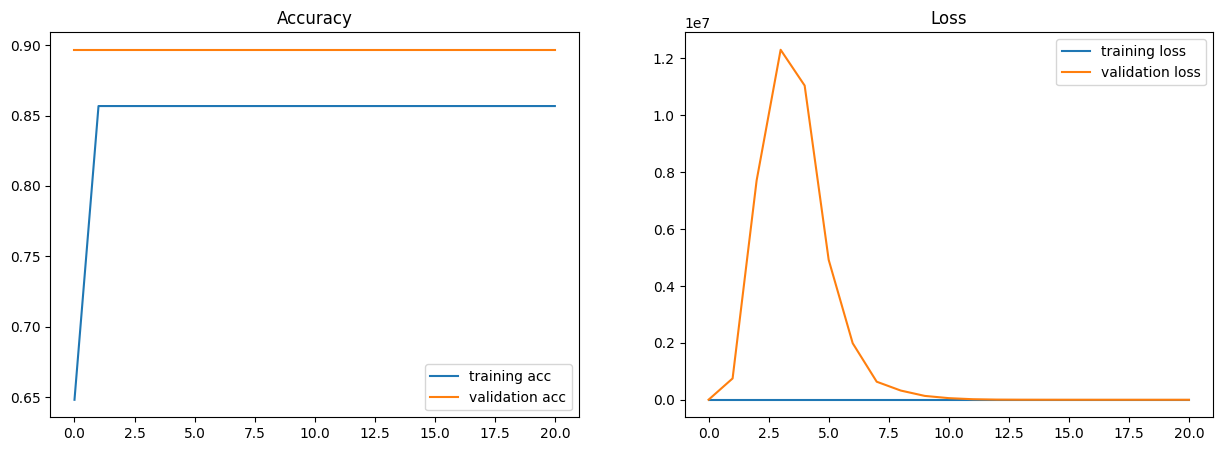

In [53]:
score5 = model5.evaluate(X_test_resized, y_test, batch_size=60, verbose=0)
print('Accuracy: {0:.0%}'.format(score5[1]/1))
print("Loss: %.4f\n" % score5[0])

# # Plot accuracy and loss graphs
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.title('Accuracy')
plt.plot(history5.history['accuracy'], label = 'training acc')
plt.plot(history5.history['val_accuracy'], label = 'validation acc')
plt.legend()

plt.subplot(1,2,2)
plt.title('Loss')
plt.plot(history5.history['loss'], label = 'training loss')
plt.plot(history5.history['val_loss'], label = 'validation loss')
plt.legend()

## VGG16

In [54]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
# Convert grayscale (1-channel) to RGB (3-channel) by repeating across 3 channels
X_train_rgb = np.repeat(X_train_reshaped, 3, axis=-1)  # Shape: (samples, 193, 193, 3)
X_test_rgb = np.repeat(X_test_reshaped, 3, axis=-1)    # Shape: (samples, 193, 193, 3)

# Resize function for batch processing
def resize_data(data, target_size=(193, 193)):
    return np.array([tf.image.resize(img, target_size).numpy() for img in data])

# Resize the dataset to match VGG16 input
X_train_resized = resize_data(X_train_rgb, target_size=(193, 193))
X_test_resized = resize_data(X_test_rgb, target_size=(193, 193))

# Load a pretrained VGG16 model
base_model_vgg = VGG16(include_top=False, input_shape=(193, 193, 3), weights="imagenet")
base_model_vgg.trainable = False  # Freeze pretrained layers

# Build the model
model_vgg = Sequential([
    base_model_vgg,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(6, activation='softmax')  # Adjust the output units for classification
])

# Compile the model
model_vgg.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Train the model
history_vgg = model_vgg.fit(
    X_train_resized, y_train,
    validation_data=(X_test_resized, y_test),
    epochs=100,
    batch_size=200,
    verbose=1
)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 104s 21s/step - accuracy: 0.5169 - loss: 3.5484 - val_accuracy: 0.8967 - val_loss: 1.3573
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.8492 - loss: 1.9834 - val_accuracy: 0.8315 - val_loss: 0.7001
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.7116 - loss: 1.5523 - val_accuracy: 0.8967 - val_loss: 0.5662
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 929ms/step - accuracy: 0.8266 - loss: 1.2144 - val_accuracy: 0.8967 - val_loss: 0.6397
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 938ms/step - accuracy: 0.8044 - loss: 1.1751 - val_accuracy: 0.8913 - val_loss: 0.5779
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 943ms/step - accuracy: 0.8106 - loss: 0.9398 - val_accuracy: 0.8967 - val_loss: 0.4315
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 973ms/step - accuracy: 0.7912 - loss: 0.9569 - val_accuracy: 0.8967 - val_loss: 0.4069
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.813

### Evaluation of VGG16

Accuracy: 90%
Loss: 0.2260



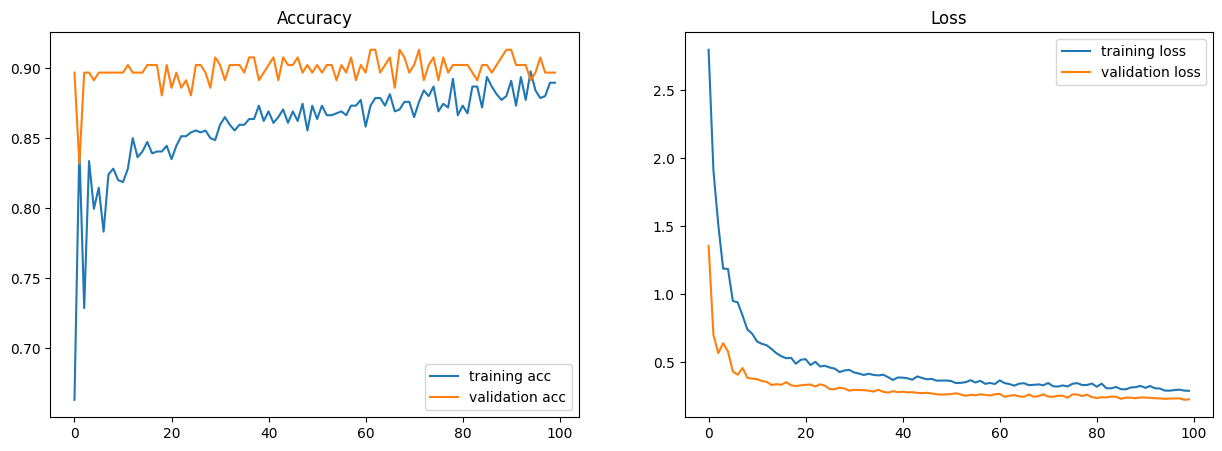

In [55]:
score7 = model_vgg.evaluate(X_test_resized, y_test, batch_size=60, verbose=0)
print('Accuracy: {0:.0%}'.format(score7[1]/1))
print("Loss: %.4f\n" % score7[0])

# Plot accuracy and loss graphs
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.title('Accuracy')
plt.plot(history_vgg.history['accuracy'], label = 'training acc')
plt.plot(history_vgg.history['val_accuracy'], label = 'validation acc')
plt.legend()

plt.subplot(1,2,2)
plt.title('Loss')
plt.plot(history_vgg.history['loss'], label = 'training loss')
plt.plot(history_vgg.history['val_loss'], label = 'validation loss')
plt.legend()

In [56]:
print('Accuracy: {0:.0%}'.format(score7[1]/1))
print("Loss: %.4f\n" % score7[0])

Accuracy: 90%
Loss: 0.2260



## VGG19

In [57]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
# Convert grayscale (1-channel) to RGB (3-channel) by repeating across 3 channels
X_train_rgb = np.repeat(X_train_reshaped, 3, axis=-1)  # Shape: (samples, 193, 193, 3)
X_test_rgb = np.repeat(X_test_reshaped, 3, axis=-1)    # Shape: (samples, 193, 193, 3)

# Resize function for batch processing
def resize_data(data, target_size=(193, 193)):
    return np.array([tf.image.resize(img, target_size).numpy() for img in data])

# Resize the dataset to match VGG16 input
X_train_resized = resize_data(X_train_rgb, target_size=(193, 193))
X_test_resized = resize_data(X_test_rgb, target_size=(193, 193))

# Load a pretrained VGG16 model
base_model_vgg19 = VGG19(include_top=False, input_shape=(193, 193, 3), weights="imagenet")
base_model_vgg19.trainable = False  # Freeze pretrained layers

# Build the model
model_vgg19 = Sequential([
    base_model_vgg19,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(6, activation='softmax')  # Adjust the output units for classification
])

# Compile the model
model_vgg19.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Train the model
history_vgg19 = model_vgg19.fit(
    X_train_resized, y_train,
    validation_data=(X_test_resized, y_test),
    epochs=100,
    batch_size=200,
    verbose=1
)

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.5911 - loss: 2.2753 - val_accuracy: 0.8967 - val_loss: 1.3626
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.8091 - loss: 1.7943 - val_accuracy: 0.8967 - val_loss: 1.0933
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.7858 - loss: 1.6317 - val_accuracy: 0.8967 - val_loss: 1.0629
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.8127 - loss: 1.4664 - val_accuracy: 0.8967 - val_loss: 0.7577
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.8141 - loss: 1.1013 - val_accuracy: 0.8967 - val_loss: 0.5359
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.8094 - loss: 0.8270 - val_accuracy: 0.8967 - val_loss: 0.4410
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.7706 - loss: 0.8421 - val_accuracy: 0.8967 - val_loss: 0.3765
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.8290 - loss: 0.730

### Evaluation of VGG19

Accuracy: 92%
Loss: 0.2485



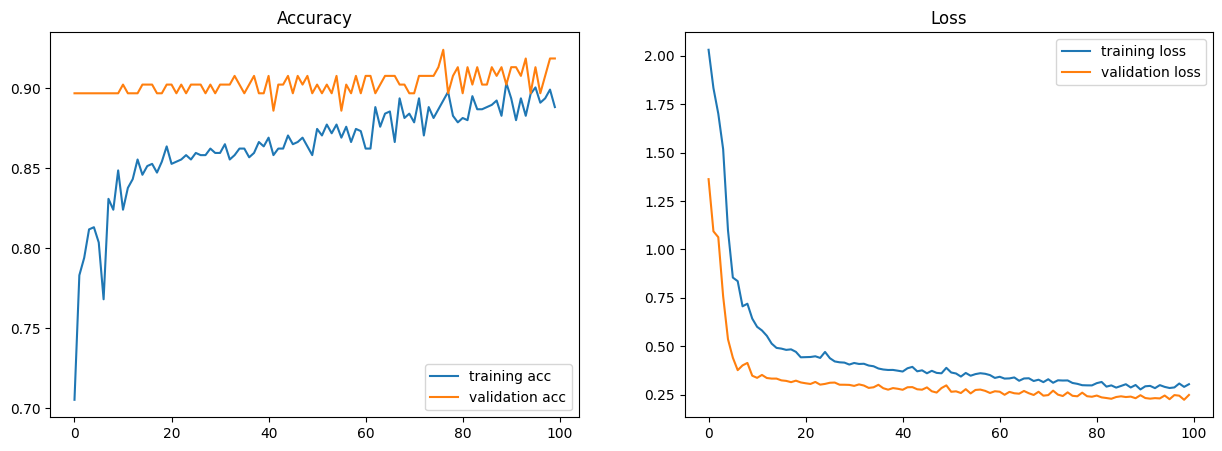

In [58]:
score8 = model_vgg19.evaluate(X_test_resized, y_test, batch_size=60, verbose=0)
print('Accuracy: {0:.0%}'.format(score8[1]/1))
print("Loss: %.4f\n" % score8[0])

# Plot accuracy and loss graphs
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.title('Accuracy')
plt.plot(history_vgg19.history['accuracy'], label = 'training acc')
plt.plot(history_vgg19.history['val_accuracy'], label = 'validation acc')
plt.legend()

plt.subplot(1,2,2)
plt.title('Loss')
plt.plot(history_vgg19.history['loss'], label = 'training loss')
plt.plot(history_vgg19.history['val_loss'], label = 'validation loss')
plt.legend()

## ResNet50

In [59]:
from tensorflow.keras.applications import ResNet50


# Resize function for batch processing
def resize_data(data, target_size=(193, 193)):
    return np.array([tf.image.resize(img, target_size).numpy() for img in data])

# Resize the dataset to match VGG16 input
X_train_resized = resize_data(X_train_rgb, target_size=(193, 193))
X_test_resized = resize_data(X_test_rgb, target_size=(193, 193))

# Load a pretrained VGG16 model
base_model_resNet50 = ResNet50(include_top=False, input_shape=(193, 193, 3), weights="imagenet")
base_model_resNet50.trainable = False  # Freeze pretrained layers


# Compile the model
model9 = Sequential([
    base_model_resNet50,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(6, activation='softmax')  # Adjust the output units for classification
])
model9.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history9 = model9.fit(X_train_resized, y_train, validation_data=(X_test_resized, y_test), epochs=100, batch_size=200, verbose=1)


Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - accuracy: 0.4748 - loss: 1.8848 - val_accuracy: 0.8967 - val_loss: 1.2536
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 580ms/step - accuracy: 0.8442 - loss: 1.6136 - val_accuracy: 0.8967 - val_loss: 0.6747
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 584ms/step - accuracy: 0.8161 - loss: 0.8110 - val_accuracy: 0.8967 - val_loss: 0.4765
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 590ms/step - accuracy: 0.8606 - loss: 0.5552 - val_accuracy: 0.8967 - val_loss: 0.3932
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 588ms/step - accuracy: 0.8660 - loss: 0.5624 - val_accuracy: 0.8967 - val_loss: 0.3461
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 597ms/step - accuracy: 0.8490 - loss: 0.5591 - val_accuracy: 0.8967 - val_loss: 0.3401
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 535ms/step - accuracy: 0.8403 - loss: 0.5195 - val_accuracy: 0.8804 - val_loss: 0.3729
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 536ms/step - accuracy: 0.8554 - loss: 0.4861 - val_accuracy: 0.8967 - val

## Evaluation of ResNet50

Accuracy: 90%
Loss: 0.2213



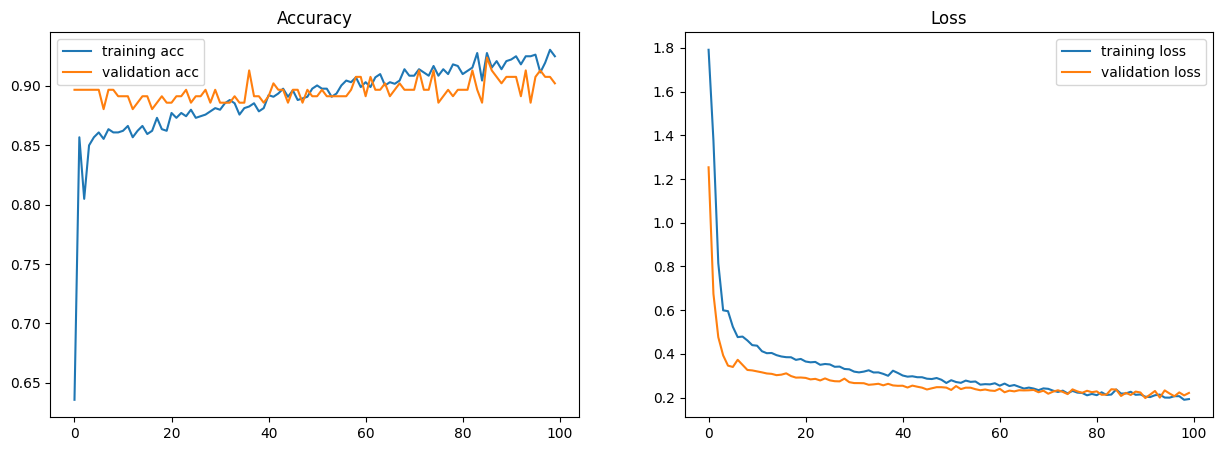

In [60]:
score9 = model9.evaluate(X_test_resized, y_test, batch_size=60, verbose=0)
print('Accuracy: {0:.0%}'.format(score9[1]/1))
print("Loss: %.4f\n" % score9[0])

# Plot accuracy and loss graphs
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.title('Accuracy')
plt.plot(history9.history['accuracy'], label = 'training acc')
plt.plot(history9.history['val_accuracy'], label = 'validation acc')
plt.legend()

plt.subplot(1,2,2)
plt.title('Loss')
plt.plot(history9.history['loss'], label = 'training loss')
plt.plot(history9.history['val_loss'], label = 'validation loss')
plt.legend()

## ResNet101

In [24]:
from tensorflow.keras.applications import ResNet101, ResNet101V2
import numpy as np
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Model

# Convert grayscale (1-channel) to RGB (3-channel) by repeating across 3 channels
X_train_rgb = np.repeat(X_train_reshaped, 3, axis=-1)  # Shape: (samples, 193, 193, 3)
X_test_rgb = np.repeat(X_test_reshaped, 3, axis=-1)    # Shape: (samples, 193, 193, 3)


# Resize function for batch processing
def resize_data(data, target_size=(193, 193)):
    return np.array([tf.image.resize(img, target_size).numpy() for img in data])

# Resize the dataset to match VGG16 input
X_train_resized = resize_data(X_train_rgb, target_size=(193, 193))
X_test_resized = resize_data(X_test_rgb, target_size=(193, 193))

# Load ResNet101 and ResNet101V2 models with ImageNet weights, excluding the top classification layers
base_model10 = ResNet101(weights='imagenet', include_top=False, input_shape=input_shape)
base_model11 = ResNet101V2(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze pretrained layers
for layer in base_model10.layers:
    layer.trainable = False

for layer in base_model11.layers:
    layer.trainable = False

# Custom layers for ResNet101
x10 = Flatten()(base_model10.output)
x10 = Dense(512, activation='relu')(x10)
output10 = Dense(6, activation='softmax')(x10)

# Custom layers for ResNet101V2
x11 = Flatten()(base_model11.output)
x11 = Dense(512, activation='relu')(x11)
output11 = Dense(6, activation='softmax')(x11)

# Compile the models
model10 = Model(inputs=base_model10.input, outputs=output10)
model10.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model11 = Model(inputs=base_model11.input, outputs=output11)
model11.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the models
history10 = model10.fit(X_train_resized, y_train, validation_data=(X_test_resized, y_test),  epochs=100, batch_size=200, verbose=1)
history11 = model11.fit(X_train_resized, y_train, validation_data=(X_test_resized, y_test),  epochs=100, batch_size=200, verbose=1)


Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 52s 11s/step - accuracy: 0.4661 - loss: 21.6057 - val_accuracy: 0.8967 - val_loss: 16.6662
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 974ms/step - accuracy: 0.7352 - loss: 22.9619 - val_accuracy: 0.8750 - val_loss: 17.1077
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 971ms/step - accuracy: 0.8469 - loss: 15.8882 - val_accuracy: 0.8804 - val_loss: 19.6550
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.8643 - loss: 17.6891 - val_accuracy: 0.8696 - val_loss: 14.2949
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.8526 - loss: 11.7277 - val_accuracy: 0.9022 - val_loss: 10.7745
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 970ms/step - accuracy: 0.8868 - loss: 8.2527 - val_accuracy: 0.8859 - val_loss: 8.2052
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.8803 - loss: 4.5800 - val_accuracy: 0.8478 - val_loss: 5.3686
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.8392 - loss: 4.5769 - val_accuracy: 0.9022 - val_

## Evaluation of ResNet101

Accuracy: 95%
Loss: 0.7152



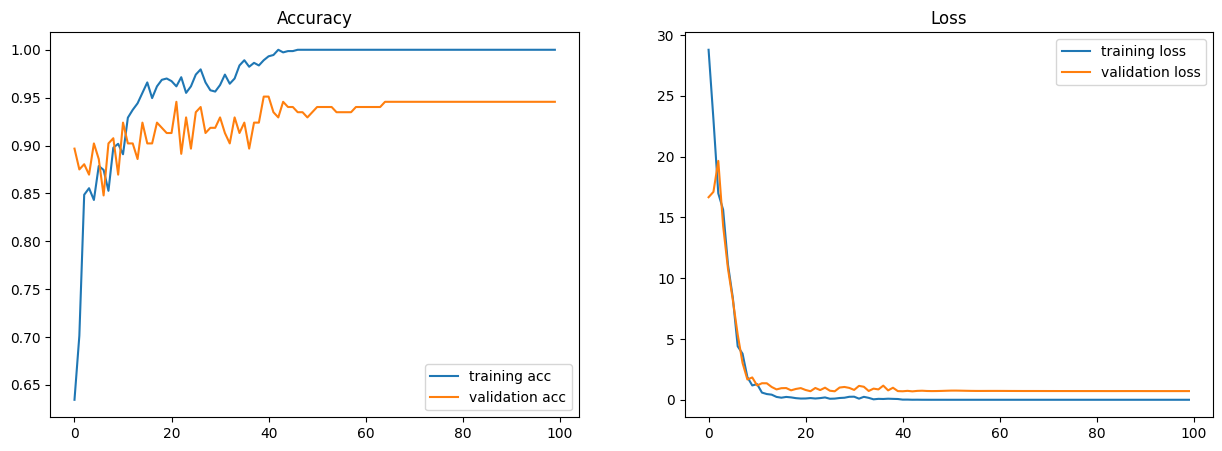

In [26]:
score10 = model10.evaluate(X_test_resized, y_test, batch_size=60, verbose=0)
print('Accuracy: {0:.0%}'.format(score10[1]/1))
print("Loss: %.4f\n" % score10[0])

# Plot accuracy and loss graphs
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.title('Accuracy')
plt.plot(history10.history['accuracy'], label = 'training acc')
plt.plot(history10.history['val_accuracy'], label = 'validation acc')
plt.legend()

plt.subplot(1,2,2)
plt.title('Loss')
plt.plot(history10.history['loss'], label = 'training loss')
plt.plot(history10.history['val_loss'], label = 'validation loss')
plt.legend()

## Evaluation of ResNet101V2

Accuracy: 95%
Loss: 19.7166



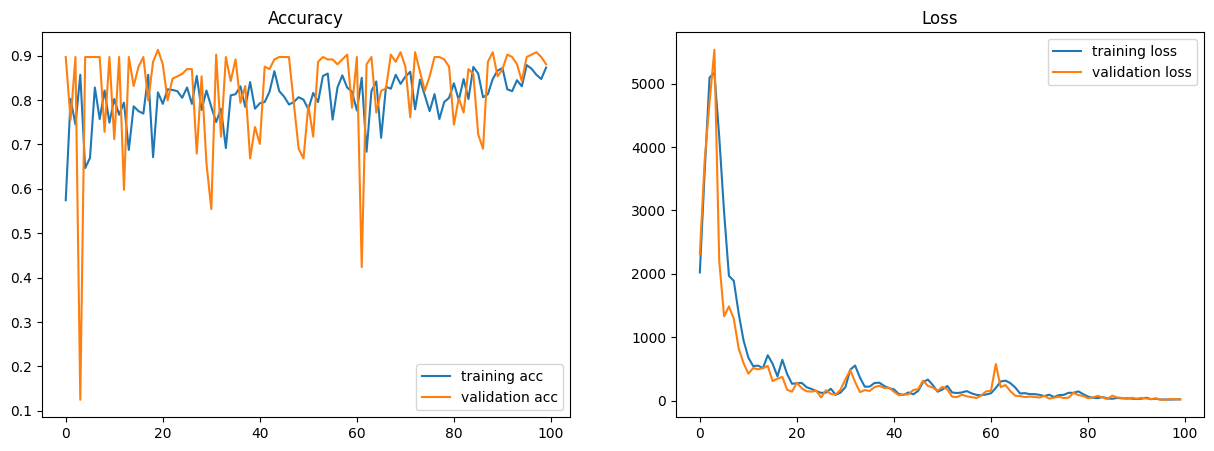

In [27]:
score11 = model11.evaluate(X_test_resized, y_test, batch_size=60, verbose=0)
print('Accuracy: {0:.0%}'.format(score10[1]/1))
print("Loss: %.4f\n" % score11[0])

# Plot accuracy and loss graphs
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.title('Accuracy')
plt.plot(history11.history['accuracy'], label = 'training acc')
plt.plot(history11.history['val_accuracy'], label = 'validation acc')
plt.legend()

plt.subplot(1,2,2)
plt.title('Loss')
plt.plot(history11.history['loss'], label = 'training loss')
plt.plot(history11.history['val_loss'], label = 'validation loss')
plt.legend()

## EfficientNet

In [30]:
from tensorflow.keras.applications import EfficientNetV2L

# # Adjust the input shape to have 3 channels
# X_train_vgg1 = np.repeat(X_train, 3, axis=-1)
# X_test_vgg1 = np.repeat(X_test, 3, axis=-1)

input_shape = (193, 193, 3)

# Load EfficientNetV2L model with ImageNet weights, excluding the top classification layers
base_model12 = EfficientNetV2L(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze pretrained layers
for layer in base_model12.layers:
    layer.trainable = False

# Custom layers
x12 = Flatten()(base_model12.output)
x12 = Dense(512, activation='relu')(x12)
output12 = Dense(6, activation='softmax')(x12)

# Compile the model
model12 = Model(inputs=base_model12.input, outputs=output12)
model12.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history12 = model12.fit(X_train_resized, y_train, validation_data=(X_test_resized, y_test),epochs=100, batch_size=200, verbose=1)

Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 236s 42s/step - accuracy: 0.7491 - loss: 13.9037 - val_accuracy: 0.5217 - val_loss: 30.1702
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.6110 - loss: 24.2852 - val_accuracy: 0.8967 - val_loss: 15.0878
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.8304 - loss: 22.0697 - val_accuracy: 0.7446 - val_loss: 10.8971
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.7427 - loss: 13.8084 - val_accuracy: 0.8913 - val_loss: 4.1989
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.8135 - loss: 7.1375 - val_accuracy: 0.8261 - val_loss: 3.1194
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.7715 - loss: 3.9289 - val_accuracy: 0.8804 - val_loss: 2.8445
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.8578 - loss: 3.1121 - val_accuracy: 0.8587 - val_loss: 3.2122
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.8319 - loss: 2.6979 - val_accuracy: 0.8478 - val_loss: 2

## Evaluation of EfficientNetV2L

Accuracy: 90%
Loss: 0.3422



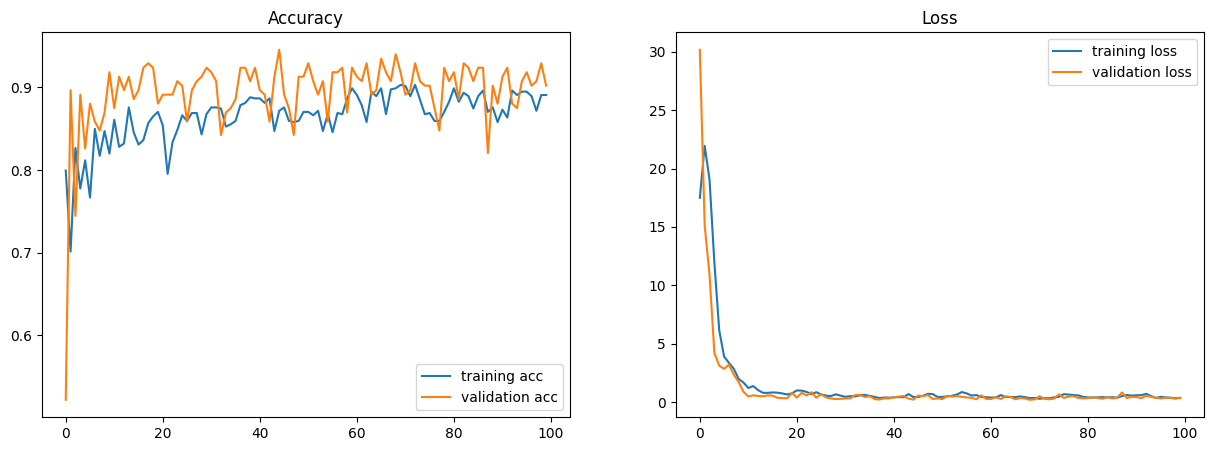

In [31]:
score12 = model12.evaluate(X_test_resized, y_test, batch_size=60, verbose=0)
print('Accuracy: {0:.0%}'.format(score12[1]/1))
print("Loss: %.4f\n" % score12[0])

# Plot accuracy and loss graphs
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.title('Accuracy')
plt.plot(history12.history['accuracy'], label = 'training acc')
plt.plot(history12.history['val_accuracy'], label = 'validation acc')
plt.legend()

plt.subplot(1,2,2)
plt.title('Loss')
plt.plot(history12.history['loss'], label = 'training loss')
plt.plot(history12.history['val_loss'], label = 'validation loss')
plt.legend()

## DenseNet

In [32]:
from tensorflow.keras.applications import DenseNet169

# Adjust the input shape to have 3 channels
# X_train_vgg1 = np.repeat(X_train, 3, axis=-1)
# X_test_vgg1 = np.repeat(X_test, 3, axis=-1)

input_shape = (193, 193, 3)

# Load DenseNet169 model with ImageNet weights, excluding the top classification layers
base_model13 = DenseNet169(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze pretrained layers
for layer in base_model13.layers:
    layer.trainable = False

# Custom layers
x13 = Flatten()(base_model13.output)
x13 = Dense(512, activation='relu')(x13)
output13 = Dense(6, activation='softmax')(x13)

# Compile the model
model13 = Model(inputs=base_model13.input, outputs=output13)
model13.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history13 = model13.fit(X_train_resized, y_train, validation_data=(X_test_resized, y_test), epochs=100, batch_size=200, verbose=1)

51877672/51877672 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 130s 23s/step - accuracy: 0.4554 - loss: 62.1375 - val_accuracy: 0.5761 - val_loss: 77.1577
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 611ms/step - accuracy: 0.6877 - loss: 86.4821 - val_accuracy: 0.7826 - val_loss: 52.3098
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 586ms/step - accuracy: 0.7881 - loss: 62.8995 - val_accuracy: 0.5761 - val_loss: 52.7419
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 588ms/step - accuracy: 0.6171 - loss: 55.2088 - val_accuracy: 0.8967 - val_loss: 38.0770
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 541ms/step - accuracy: 0.8275 - loss: 58.5512 - val_accuracy: 0.9022 - val_loss: 30.3401
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 596ms/step - accuracy: 0.8089 - loss: 42.3195 - val_accuracy: 0.8859 - val_loss: 24.5070
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 591ms/step - accuracy: 0.8486 - loss: 24.1261 - val_accuracy: 0.8478 - val_loss: 19.0100
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 586ms/

## Evaluation of DenseNet169

Accuracy: 90%
Loss: 0.6032



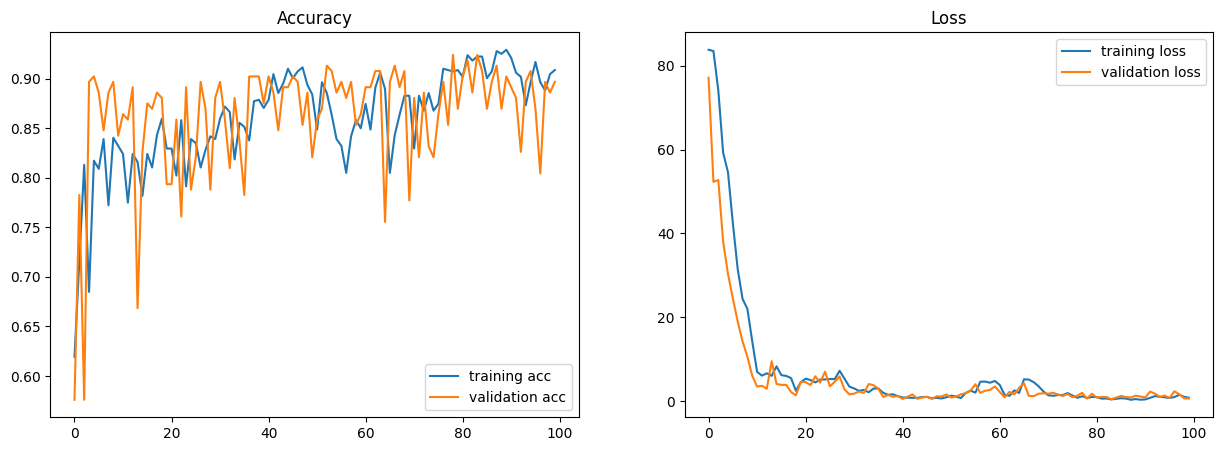

In [33]:
score13 = model13.evaluate(X_test_resized, y_test, batch_size=60, verbose=0)
print('Accuracy: {0:.0%}'.format(score13[1]/1))
print("Loss: %.4f\n" % score13[0])

# Plot accuracy and loss graphs
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.title('Accuracy')
plt.plot(history13.history['accuracy'], label = 'training acc')
plt.plot(history13.history['val_accuracy'], label = 'validation acc')
plt.legend()

plt.subplot(1,2,2)
plt.title('Loss')
plt.plot(history13.history['loss'], label = 'training loss')
plt.plot(history13.history['val_loss'], label = 'validation loss')
plt.legend()

# WaveNet

In [34]:
from tensorflow.keras.layers import Input, Conv1D, Dense, Flatten, Activation, Add

# Ensure input shape is (batch_size, time_steps, channels)
if X_train.ndim == 3 and X_train.shape[-1] != 1:  # Shape: (batch_size, time_steps, channels)
    X_train = np.mean(X_train, axis=-1, keepdims=True)  # Convert to (batch_size, time_steps, 1)
    X_test = np.mean(X_test, axis=-1, keepdims=True)

input_shape = (X_train.shape[1], X_train.shape[2])  # (time_steps, channels)

# WaveNet-style causal convolutional block
def residual_block(x, dilation_rate):
    res = x
    x = Conv1D(filters=64, kernel_size=2, padding="causal", dilation_rate=dilation_rate, activation="relu")(x)
    x = Conv1D(filters=64, kernel_size=2, padding="causal", dilation_rate=dilation_rate)(x)
    x = Add()([x, res])  # Residual connection
    x = Activation("relu")(x)
    return x

# Input layer
inputs = Input(shape=input_shape)

# First convolution (non-causal)
x = Conv1D(filters=64, kernel_size=2, padding="same", activation="relu")(inputs)

# Stack of residual blocks with increasing dilation rates
dilations = [1, 2, 4, 8, 16, 32]
for dilation in dilations:
    x = residual_block(x, dilation)

# Flatten and output layer
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
outputs = Dense(6, activation='softmax')(x)  # Assuming 6 classes

# Compile the model
model_wavenet = Model(inputs, outputs)
model_wavenet.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# Train the model
history_wavenet = model_wavenet.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=200, verbose=1)

Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.5273 - loss: 32.3251 - val_accuracy: 0.8967 - val_loss: 28.3200
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.8515 - loss: 40.3893 - val_accuracy: 0.8587 - val_loss: 17.5404
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.7483 - loss: 20.3675 - val_accuracy: 0.8533 - val_loss: 7.2156
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.7684 - loss: 8.8054 - val_accuracy: 0.8967 - val_loss: 3.9445
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8560 - loss: 5.1097 - val_accuracy: 0.8587 - val_loss: 3.7854
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8157 - loss: 4.6322 - val_accuracy: 0.8804 - val_loss: 2.7359
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.8473 - loss: 3.2500 - val_accuracy: 0.8261 - val_loss: 1.9841
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.7874 - loss: 2.6772 - val_accuracy: 0.8696 - val_l

## Efficiency of WaveNet

Accuracy: 93%
Loss: 0.2207



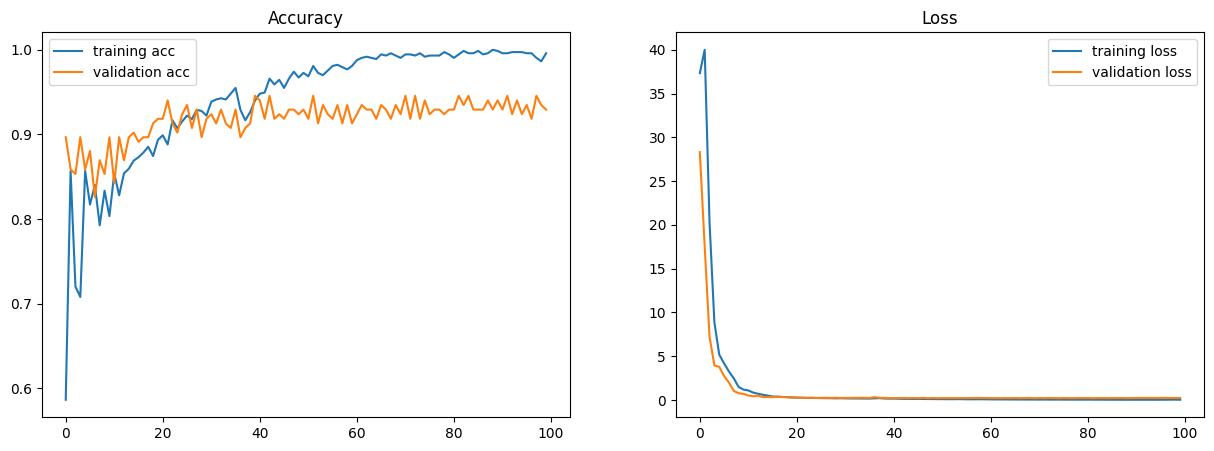

In [35]:
score_waveNet = model_wavenet.evaluate(X_test, y_test, batch_size=60, verbose=0)
print('Accuracy: {0:.0%}'.format(score_waveNet[1]/1))
print("Loss: %.4f\n" % score_waveNet[0])

# Plot accuracy and loss graphs
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.title('Accuracy')
plt.plot(history_wavenet.history['accuracy'], label = 'training acc')
plt.plot(history_wavenet.history['val_accuracy'], label = 'validation acc')
plt.legend()

plt.subplot(1,2,2)
plt.title('Loss')
plt.plot(history_wavenet.history['loss'], label = 'training loss')
plt.plot(history_wavenet.history['val_loss'], label = 'validation loss')
plt.legend()

## SoundNet

In [36]:
# Ensure input shape is (batch_size, time_steps, channels)
if X_train.ndim == 3 and X_train.shape[-1] != 1:  # Shape: (batch_size, time_steps, channels)
    X_train = np.mean(X_train, axis=-1, keepdims=True)  # Convert to (batch_size, time_steps, 1)
    X_test = np.mean(X_test, axis=-1, keepdims=True)

input_shape = (X_train.shape[1], X_train.shape[2])  # (time_steps, channels)

# Input layer
inputs = Input(shape=input_shape)

# SoundNet-style convolutional layers
x = Conv1D(filters=16, kernel_size=3, strides=1, activation='relu', padding='same')(inputs)
x = MaxPooling1D(pool_size=2, strides=2)(x)

x = Conv1D(filters=32, kernel_size=3, strides=1, activation='relu', padding='same')(x)
x = MaxPooling1D(pool_size=2, strides=2)(x)

x = Conv1D(filters=64, kernel_size=3, strides=1, activation='relu', padding='same')(x)
x = MaxPooling1D(pool_size=2, strides=2)(x)

x = Conv1D(filters=128, kernel_size=3, strides=1, activation='relu', padding='same')(x)
x = MaxPooling1D(pool_size=2, strides=2)(x)

x = Conv1D(filters=256, kernel_size=3, strides=1, activation='relu', padding='same')(x)
x = MaxPooling1D(pool_size=2, strides=2)(x)

x = Conv1D(filters=512, kernel_size=3, strides=1, activation='relu', padding='same')(x)

# Flatten and classification layers
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
outputs = Dense(6, activation='softmax')(x)  # Assuming 6 classes

# Compile the model
model_soundnet = Model(inputs, outputs)
model_soundnet.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# Train the model
history_soundnet = model_soundnet.fit(X_train, y_train, validation_data=(X_test, y_test),  epochs=100, batch_size=200, verbose=1)


Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.6575 - loss: 2.2571 - val_accuracy: 0.8967 - val_loss: 0.5949
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.8590 - loss: 0.9039 - val_accuracy: 0.8967 - val_loss: 0.5356
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8625 - loss: 0.8065 - val_accuracy: 0.8967 - val_loss: 0.4773
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8430 - loss: 0.6509 - val_accuracy: 0.8967 - val_loss: 0.4433
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8587 - loss: 0.5611 - val_accuracy: 0.8967 - val_loss: 0.4275
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8512 - loss: 0.5573 - val_accuracy: 0.8967 - val_loss: 0.3932
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8564 - loss: 0.5200 - val_accuracy: 0.8967 - val_loss: 0.3894
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8590 - loss: 0.4797 - val_accuracy: 0.8967 - val_loss: 0

### Efficiency of soundNet

Accuracy: 92%
Loss: 0.2078



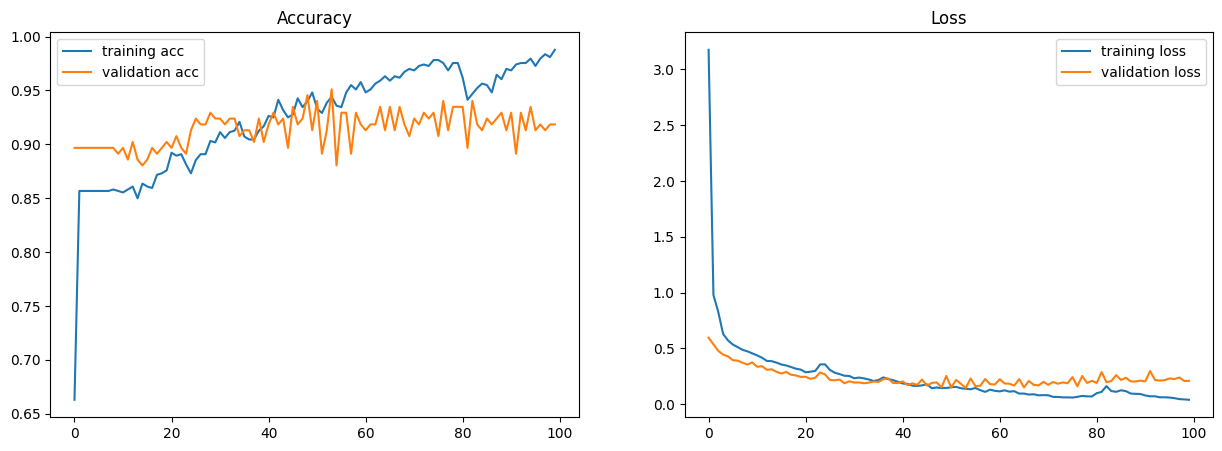

In [37]:
score_soundNet = model_soundnet.evaluate(X_test, y_test, batch_size=60, verbose=0)
print('Accuracy: {0:.0%}'.format(score_soundNet[1]/1))
print("Loss: %.4f\n" % score_soundNet[0])

# Plot accuracy and loss graphs
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.title('Accuracy')
plt.plot(history_soundnet.history['accuracy'], label = 'training acc')
plt.plot(history_soundnet.history['val_accuracy'], label = 'validation acc')
plt.legend()

plt.subplot(1,2,2)
plt.title('Loss')
plt.plot(history_soundnet.history['loss'], label = 'training loss')
plt.plot(history_soundnet.history['val_loss'], label = 'validation loss')
plt.legend()

## VGGish

In [38]:

from tensorflow.keras.layers import BatchNormalization, Dropout


# Ensure input shape is (batch_size, time_steps, channels)
if X_train.ndim == 3 and X_train.shape[-1] != 1:  # Shape: (batch_size, time_steps, channels)
    X_train = np.mean(X_train, axis=-1, keepdims=True)  # Convert to (batch_size, time_steps, 1)
    X_test = np.mean(X_test, axis=-1, keepdims=True)

input_shape = (X_train.shape[1], X_train.shape[2])  # (time_steps, channels)

# Input layer
inputs = Input(shape=input_shape)

# VGGish-style convolutional layers
x = Conv1D(filters=64, kernel_size=3, strides=1, activation='relu', padding='same')(inputs)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=2, strides=2)(x)

x = Conv1D(filters=128, kernel_size=3, strides=1, activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=2, strides=2)(x)

x = Conv1D(filters=256, kernel_size=3, strides=1, activation='relu', padding='same')(x)
x = Conv1D(filters=256, kernel_size=3, strides=1, activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=2, strides=2)(x)

x = Conv1D(filters=512, kernel_size=3, strides=1, activation='relu', padding='same')(x)
x = Conv1D(filters=512, kernel_size=3, strides=1, activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=2, strides=2)(x)

# Flatten and fully connected layers
x = Flatten()(x)
x = Dense(4096, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(4096, activation='relu')(x)
x = Dropout(0.5)(x)

outputs = Dense(6, activation='softmax')(x)  # Assuming 6 classes

# Compile the model
model_vggish = Model(inputs, outputs)
model_vggish.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# Train the model
history_vggish = model_vggish.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=200, verbose=1)


Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 28s 4s/step - accuracy: 0.4993 - loss: 9.3497 - val_accuracy: 0.8967 - val_loss: 2.8829
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 20s 93ms/step - accuracy: 0.6794 - loss: 1.2304 - val_accuracy: 0.8967 - val_loss: 1.5362
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.8483 - loss: 0.6112 - val_accuracy: 0.8967 - val_loss: 1.0766
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.8587 - loss: 0.5710 - val_accuracy: 0.7935 - val_loss: 0.9368
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8610 - loss: 0.5238 - val_accuracy: 0.8587 - val_loss: 0.8235
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.8549 - loss: 0.5139 - val_accuracy: 0.8424 - val_loss: 0.7379
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.8468 - loss: 0.5342 - val_accuracy: 0.7500 - val_loss: 0.7524
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.8545 - loss: 0.4817 - val_accuracy: 0.8967 - val_loss:

## Efficiency of VGGish

Accuracy: 90%
Loss: 0.5135



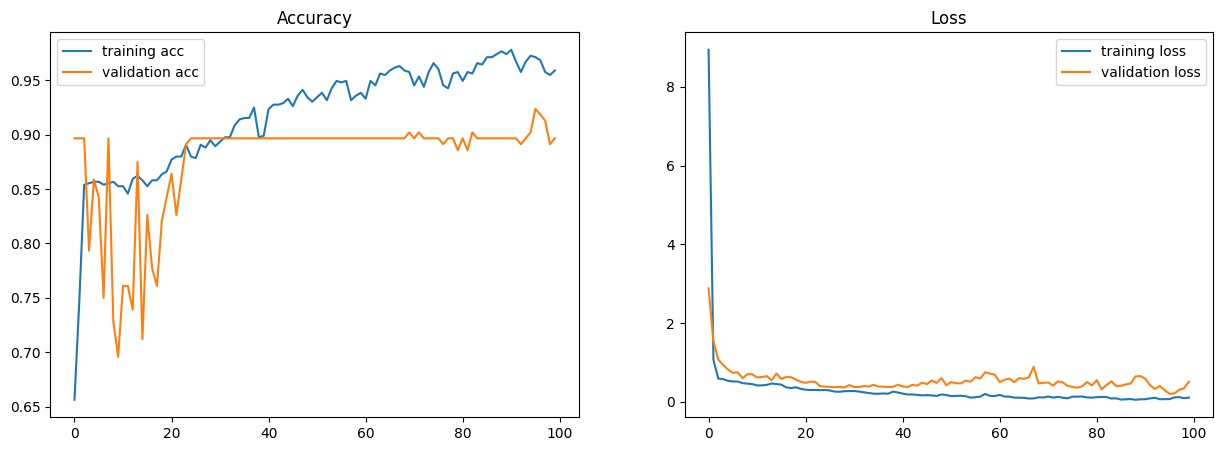

In [39]:
score_vggish = model_vggish.evaluate(X_test, y_test, batch_size=60, verbose=0)
print('Accuracy: {0:.0%}'.format(score_vggish[1]/1))
print("Loss: %.4f\n" % score_vggish[0])

# Plot accuracy and loss graphs
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.title('Accuracy')
plt.plot(history_vggish.history['accuracy'], label = 'training acc')
plt.plot(history_vggish.history['val_accuracy'], label = 'validation acc')
plt.legend()

plt.subplot(1,2,2)
plt.title('Loss')
plt.plot(history_vggish.history['loss'], label = 'training loss')
plt.plot(history_vggish.history['val_loss'], label = 'validation loss')
plt.legend()

## DenseNet

In [ ]:

from tensorflow.keras.applications import DenseNet121


# Convert grayscale (1-channel) to RGB (3-channel) by repeating across 3 channels
X_train_rgb = np.repeat(X_train_reshaped, 3, axis=-1)  # Shape: (samples, 193, 193, 3)
X_test_rgb = np.repeat(X_test_reshaped, 3, axis=-1)    # Shape: (samples, 193, 193, 3)

# Resize function for batch processing
def resize_data(data, target_size=(193, 193)):
    return np.array([tf.image.resize(img, target_size).numpy() for img in data])

# Resize the dataset to match DenseNet input
X_train_resized = resize_data(X_train_rgb, target_size=(193, 193))
X_test_resized = resize_data(X_test_rgb, target_size=(193, 193))

# Load a pretrained DenseNet121 model
base_model_densenet = DenseNet121(include_top=False, input_shape=(193, 193, 3), weights="imagenet")
base_model_densenet.trainable = False  # Freeze pretrained layers

# Build the model
model_densenet = Sequential([
    base_model_densenet,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(6, activation='softmax')  # Adjust the output units for classification
])

# Compile the model
model_densenet.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Train the model
history_densenet = model_densenet.fit(
    X_train_resized, y_train,
    validation_data=(X_test_resized, y_test),
    epochs=100,
    batch_size=200,
    verbose=1
)


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.4263 - loss: 7.0898   

## Efficiency of DenseNet

Accuracy: 14%
Loss: 7.3010



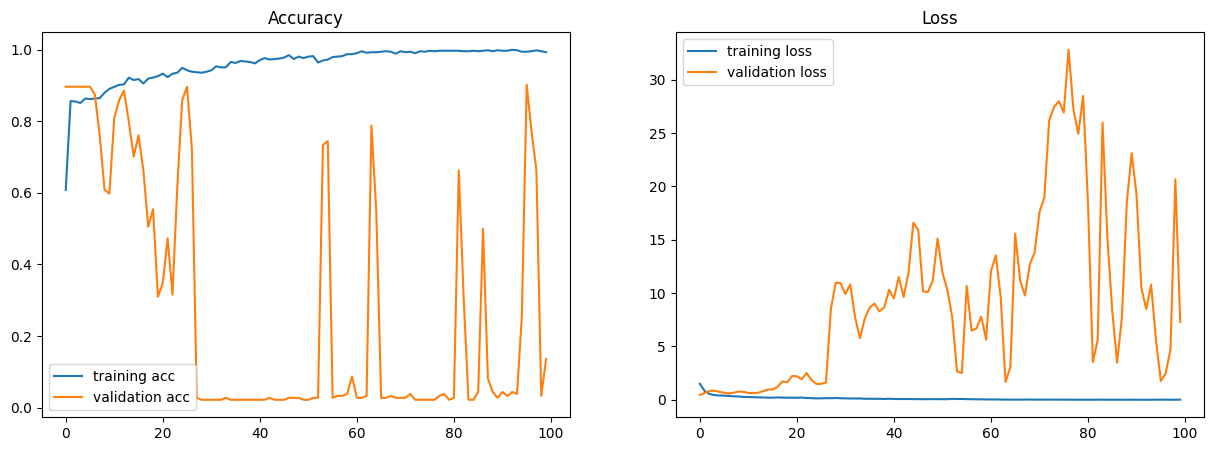

In [41]:
score_densenet = model_densenet.evaluate(X_test, y_test, batch_size=60, verbose=0)
print('Accuracy: {0:.0%}'.format(score_densenet[1]/1))
print("Loss: %.4f\n" % score_densenet[0])

# Plot accuracy and loss graphs
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.title('Accuracy')
plt.plot(history_densenet.history['accuracy'], label = 'training acc')
plt.plot(history_densenet.history['val_accuracy'], label = 'validation acc')
plt.legend()

plt.subplot(1,2,2)
plt.title('Loss')
plt.plot(history_densenet.history['loss'], label = 'training loss')
plt.plot(history_densenet.history['val_loss'], label = 'validation loss')
plt.legend()

In [ ]:

# matrix_index = ["COPD", "Healthy", "URTI", "Bronchiectasis", "Pneumoina", "Bronchiolitis"]

# preds = model.predict(X_test)
# classpreds = np.argmax(preds, axis=1) # predicted classes
# y_testclass = np.argmax(y_test, axis=1) # true classes

# cm = confusion_matrix(y_testclass, classpreds)
# print(classification_report(y_testclass, classpreds, target_names=matrix_index))

# # Get percentage value for each element of the matrix
# cm_sum = np.sum(cm, axis=1, keepdims=True)
# cm_perc = cm / cm_sum.astype(float) * 100
# annot = np.empty_like(cm).astype(str)
# nrows, ncols = cm.shape
# for i in range(nrows):
#     for j in range(ncols):
#         c = cm[i, j]
#         p = cm_perc[i, j]
#         if i == j:
#             s = cm_sum[i]
#             annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
#         elif c == 0:
#             annot[i, j] = ''
#         else:
#             annot[i, j] = '%.1f%%\n%d' % (p, c)


# # Display confusion matrix
# df_cm = pd.DataFrame(cm, index = matrix_index, columns = matrix_index)
# df_cm.index.name = 'Actual'
# df_cm.columns.name = 'Predicted'
# fig, ax = plt.subplots(figsize=(10,7))
# sn.heatmap(df_cm, annot=annot, fmt='')